# Using Predictive Analytics to Predict Delays in Maritime Container Shipping

In [1]:
%matplotlib inline

**Import Libraries**

In [10]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import Levenshtein

import warnings
#https://github.com/pandas-dev/pandas/issues/8509
warnings.filterwarnings('ignore', 'numpy not_equal will not check object identity in the future')

#http://pythondata.com/dask-large-csv-python/
#import dask.dataframe as dd
 
#from collections import Counter
#from patsy import dmatrices
#import statsmodels.api as sm

#https://www.dataquest.io/blog/pandas-big-data/

**Read in file**

In [3]:
df = pd.read_pickle('2014_data_LA_SH.pkl')

In [4]:
#check that all rows imported
df.shape

(652470, 28)

In [5]:
#check datatypes
df.dtypes

identifier                             uint64
trade_update_date              datetime64[ns]
run_date                       datetime64[ns]
vessel_name                          category
port_of_unlading                     category
estimated_arrival_date         datetime64[ns]
foreign_port_of_lading               category
record_status_indicator              category
place_of_receipt                     category
port_of_destination                  category
foreign_port_of_destination          category
actual_arrival_date            datetime64[ns]
consignee_name                       category
shipper_party_name                   category
container_number                     category
description_sequence_number            uint64
piece_count                            uint64
description_text                     category
carrier                              category
day_of_week_est                         uint8
day_of_week_act                         uint8
month_est                         

In [6]:
df.head()

,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,carrier,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,prior_est_arr_date,same_as_prior,new_voyage,voyage
774240,2014052738644,2014-05-09,2014-05-27,9294800,"Long Beach, California",2014-05-25,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,9294800,6,0,5,5,1,NaT,False,1,1
7714174,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,9337937,4,3,2,2,6,NaT,False,1,1
7714175,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,9337937,4,3,2,2,6,2014-02-14,True,0,1
7714176,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,9337937,4,3,2,2,6,2014-02-14,True,0,1
2726421,2014022134266,2014-01-29,2014-02-21,9337937,"Los Angeles, California",2014-02-15,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,9337937,5,3,2,2,5,2014-02-14,True,0,1


In [7]:
list(df)

['identifier',
 'trade_update_date',
 'run_date',
 'vessel_name',
 'port_of_unlading',
 'estimated_arrival_date',
 'foreign_port_of_lading',
 'record_status_indicator',
 'place_of_receipt',
 'port_of_destination',
 'foreign_port_of_destination',
 'actual_arrival_date',
 'consignee_name',
 'shipper_party_name',
 'container_number',
 'description_sequence_number',
 'piece_count',
 'description_text',
 'carrier',
 'day_of_week_est',
 'day_of_week_act',
 'month_est',
 'month_act',
 'delay_days',
 'prior_est_arr_date',
 'same_as_prior',
 'new_voyage',
 'voyage']

In [151]:
#create a data frame with the fields that we will group often
df_sub = df[['trade_update_date','run_date','vessel_name','port_of_unlading','estimated_arrival_date',
 'foreign_port_of_lading', 'record_status_indicator','actual_arrival_date','consignee_name',
 'shipper_party_name','voyage','month_est']]

In [155]:
#create a data frame with the fields that we will group often
df_sub2 = df[['trade_update_date','run_date','vessel_name','port_of_unlading','estimated_arrival_date',
 'foreign_port_of_lading', 'record_status_indicator','actual_arrival_date','voyage','month_est']]

** The estimated arrival dates appear to be completely random, it's possible they're just putting something in the system because they have to but these aren't dates that anyone relies on **

For each vessel voyage, get:
- most common estimated arrival date / number of unique estimated arrival dates
- most common actual arrival date/ number of unique arrival dates
- average delay days / range of delay days
- number of observations / number of shippers / number of consignees

In [21]:
'''
#groupby template
#get min and max delay by vessel name and voyage
delay_by_voyage = df_v_LA[['vessel_name','voyage','delay_days']].groupby(['vessel_name','voyage'],as_index=False).agg([min,max])

#reformat columns
delay_by_voyage.columns = ['_'.join(tup).rstrip('_') for tup in delay_by_voyage.columns.values]
delay_by_voyage.reset_index(col_level=1,inplace = True)
delay_by_voyage.head()
'''

"\n#groupby template\n#get min and max delay by vessel name and voyage\ndelay_by_voyage = df_v_LA[['vessel_name','voyage','delay_days']].groupby(['vessel_name','voyage'],as_index=False).agg([min,max])\n\n#reformat columns\ndelay_by_voyage.columns = ['_'.join(tup).rstrip('_') for tup in delay_by_voyage.columns.values]\ndelay_by_voyage.reset_index(col_level=1,inplace = True)\ndelay_by_voyage.head()\n"

** View the unique counts by vessel_name and voyage and view distributions **

In [36]:
#get the unique counts
voyage_stats = df.groupby(['vessel_name','voyage']
          )['identifier','record_status_indicator','foreign_port_of_lading','port_of_unlading',
            'trade_update_date','run_date','estimated_arrival_date','actual_arrival_date',
            'container_number','consignee_name','shipper_party_name'].nunique()

#flatten the index to make it easier to work with
voyage_stats.reset_index(col_level=1,inplace = True)

In [37]:
#view the top 5 entries sorted by the largest numbers of 'containers'
voyage_stats.sort_values('container_number',ascending = False).head()

,vessel_name,voyage,identifier,record_status_indicator,foreign_port_of_lading,port_of_unlading,trade_update_date,run_date,estimated_arrival_date,actual_arrival_date,container_number,consignee_name,shipper_party_name
342,CSCL BOHAI SEA,1,2161,2,1,2,66,33,25,6,3647,1517,1527
351,CSCL SPRING,5,2960,2,1,2,87,31,47,7,3622,1365,1441
500,HANJIN NEW YORK,2,3302,2,1,2,80,38,46,10,3051,1392,1529
462,HANJIN KOREA,2,3190,2,1,2,81,31,49,8,2946,1256,1363
867,OOCL OAKLAND,1,2499,2,1,2,72,36,42,6,2546,1179,1264


In [45]:
#actual arrival date greater than one - this may indicate more than one voyage
#voyage splitting function didn't accurately split them
(len(voyage_stats),
 len(voyage_stats[voyage_stats.actual_arrival_date > 1]),
 len(voyage_stats[voyage_stats.actual_arrival_date > 2]), 
 len(voyage_stats[voyage_stats.actual_arrival_date > 5]) )

(1048, 403, 199, 31)

In [49]:
voyage_stats[voyage_stats.actual_arrival_date > 5][['vessel_name','voyage','actual_arrival_date']].head()

,vessel_name,voyage,actual_arrival_date
42,APL ENGLAND,5,9
43,APL ENGLAND,6,6
51,APL HOLLAND,5,6
67,APL PHILIPPINES,1,6
109,BAI CHAY BRIDGE,4,10


In [58]:
#view one of the vessel voyages with more than 5 actual_arrival_dates
df_sub[(df_sub.vessel_name.str.contains('APL ENGLAND')) & (df_sub.voyage == 5)]['actual_arrival_date'].unique()

array(['2014-07-29T00:00:00.000000000', '2014-08-02T00:00:00.000000000',
       '2014-09-02T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
       '2014-10-12T00:00:00.000000000', '2014-10-09T00:00:00.000000000',
       '2014-10-10T00:00:00.000000000', '2014-10-08T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000'], dtype='datetime64[ns]')

** Group by actual arrival date to get closer to the actual voyages and compare to voyages based on estimated arrival date **

In [68]:
#get groupings from actual arrival dates (there should be less variation in actual arrival dates)
def voyageSplitAct(df,d):
    #sort by vessel,then by estimated arrival date, then by port_of_unlading
    df = df.sort_values(['vessel_name','actual_arrival_date'])
    #groupby vessel_name and shift the estimated_arrival_date down one row to compare current to prior
    df['prior_act_arr_date'] = df.groupby(['vessel_name'])['actual_arrival_date'].shift()
    #check if the prior date is within d days of the prior estimated arrival date
    df['same_as_prior_act'] = df.actual_arrival_date <= (df.prior_act_arr_date + timedelta(days=d))
    #for all false in same as prior enter 1 otherwise enter 0, then implement a running sum to get the voyage numbers
    df['new_voyage_act'] = ~df.same_as_prior_act * 1
    #implement a running sum
    df['voyage_act'] = df.groupby('vessel_name')['new_voyage_act'].cumsum()
    return df

In [69]:
def voyageSplitEst(df,d):
    #sort by vessel,then by estimated arrival date, then by port_of_unlading
    df = df.sort_values(['vessel_name','estimated_arrival_date'])
    #groupby vessel_name and shift the estimated_arrival_date down one row to compare current to prior
    df['prior_est_arr_date'] = df.groupby(['vessel_name'])['estimated_arrival_date'].shift()
    #check if the prior date is within d days of the prior estimated arrival date
    df['same_as_prior'] = df.estimated_arrival_date <= (df.prior_est_arr_date + timedelta(days=d))
    #for all false in same as prior enter 1 otherwise enter 0, then implement a running sum to get the voyage numbers
    df['new_voyage'] = ~df.same_as_prior * 1
    #implement a running sum
    df['voyage'] = df.groupby('vessel_name')['new_voyage'].cumsum()
    return df

In [140]:
#set d to 15 since voyages are roughly a month apart
d = 15

In [ ]:
df2[df2.]

In [141]:
df2 = voyageSplitEst(df,d)
df3 = voyageSplitAct(df2,d)

In [142]:
len(df3), len(df3[df3.voyage != df3.voyage_act])

(652470, 259101)

In [72]:
df3.head()

,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,month_act,delay_days,prior_est_arr_date,same_as_prior,new_voyage,voyage,prior_act_arr_date,same_as_prior_act,new_voyage_act,voyage_act
774240,2014052738644,2014-05-09,2014-05-27,9294800,"Long Beach, California",2014-05-25,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,5,1,NaT,False,1,1,NaT,False,1,1
7714174,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,2,6,NaT,False,1,1,NaT,False,1,1
7714175,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,2,6,2014-02-14,True,0,1,2014-02-20,True,0,1
7714176,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,2,6,2014-02-14,True,0,1,2014-02-20,True,0,1
2726421,2014022134266,2014-01-29,2014-02-21,9337937,"Los Angeles, California",2014-02-15,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,2,5,2014-02-14,True,0,1,2014-02-20,True,0,1


In [64]:
df2.head()

,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,carrier,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,prior_est_arr_date,same_as_prior,new_voyage,voyage
774240,2014052738644,2014-05-09,2014-05-27,9294800,"Long Beach, California",2014-05-25,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,9294800,6,0,5,5,1,NaT,False,1,1
7714174,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,9337937,4,3,2,2,6,NaT,False,1,1
7714175,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,9337937,4,3,2,2,6,2014-02-14,True,0,1
7714176,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,9337937,4,3,2,2,6,2014-02-14,True,0,1
2726421,2014022134266,2014-01-29,2014-02-21,9337937,"Los Angeles, California",2014-02-15,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,9337937,5,3,2,2,5,2014-02-14,True,0,1


** Get voyage stats by month, vessel split is not very reliable **
- This will pick up two different vessel runs in one month but that will have to be the assumption

In [143]:
#get the unique counts
voyage_stats = df.groupby(['vessel_name','month_est']
          )['identifier','record_status_indicator','foreign_port_of_lading','port_of_unlading',
            'trade_update_date','run_date','estimated_arrival_date','actual_arrival_date',
            'container_number','consignee_name','shipper_party_name'].nunique()

#flatten the index to make it easier to work with
voyage_stats.reset_index(col_level=1,inplace = True)

In [149]:
voyage_stats.sort_values('actual_arrival_date', ascending = False).head()

,vessel_name,month_est,identifier,record_status_indicator,foreign_port_of_lading,port_of_unlading,trade_update_date,run_date,estimated_arrival_date,actual_arrival_date,container_number,consignee_name,shipper_party_name
1140,OOCL KUALA LUMPUR,11,991,2,1,2,37,23,16,14,866,424,470
622,HANJIN LONG BEACH,10,2383,2,1,2,32,19,18,12,1460,929,1011
1132,OOCL ITALY,11,517,2,1,2,19,19,12,11,445,241,276
464,CSCL WINTER,12,376,2,1,2,21,8,18,9,414,245,257
337,COSCO EUROPE,10,1865,2,1,2,35,28,16,8,1037,707,743


In [219]:
#view one of the vessel voyages with multiple actual_arrival_dates
df_sub[(df_sub.vessel_name.str.contains('OOCL KUALA LUMPUR'))& 
       (df_sub.port_of_unlading.str.contains('Los Angeles, California')) & 
       (df_sub.month_est == 11)
        ]['actual_arrival_date'].unique()

array(['2014-11-17T00:00:00.000000000', '2014-11-18T00:00:00.000000000',
       '2014-11-21T00:00:00.000000000', '2014-11-20T00:00:00.000000000',
       '2014-11-08T00:00:00.000000000', '2014-11-22T00:00:00.000000000',
       '2014-11-14T00:00:00.000000000', '2014-11-19T00:00:00.000000000',
       '2014-11-24T00:00:00.000000000', '2014-11-23T00:00:00.000000000'], dtype='datetime64[ns]')

In [161]:
#view the vessel data
df_sub2[(df_sub2.vessel_name.str.contains('OOCL KUALA LUMPUR')) &
        (df_sub2.month_est == 11)].drop_duplicates().sort_values('actual_arrival_date')[50:100]
#estimated arrival date looks much earlier - looks like it might have gone on an earlier shipment

,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,actual_arrival_date,voyage,month_est
1785501,2014-10-20,2014-11-24,OOCL KUALA LUMPUR,"Long Beach, California",2014-11-04,"Shanghai ,China (Mainland)",Amended,2014-11-08,3,11
3515812,2014-10-20,2014-12-04,OOCL KUALA LUMPUR,"Long Beach, California",2014-11-04,"Shanghai ,China (Mainland)",Amended,2014-11-08,3,11
7641874,2014-10-24,2014-11-25,OOCL KUALA LUMPUR,"Long Beach, California",2014-11-05,"Shanghai ,China (Mainland)",Amended,2014-11-08,3,11
8210929,2014-10-20,2014-11-26,OOCL KUALA LUMPUR,"Long Beach, California",2014-11-05,"Shanghai ,China (Mainland)",Amended,2014-11-08,3,11
7915385,2014-10-21,2014-11-10,OOCL KUALA LUMPUR,"Long Beach, California",2014-11-04,"Shanghai ,China (Mainland)",New,2014-11-08,3,11
8786743,2014-10-20,2014-12-04,OOCL KUALA LUMPUR,"Long Beach, California",2014-11-05,"Shanghai ,China (Mainland)",Amended,2014-11-08,3,11
9366423,2014-10-20,2014-11-25,OOCL KUALA LUMPUR,"Long Beach, California",2014-11-05,"Shanghai ,China (Mainland)",Amended,2014-11-08,3,11
10230951,2014-10-20,2014-11-24,OOCL KUALA LUMPUR,"Long Beach, California",2014-11-05,"Shanghai ,China (Mainland)",Amended,2014-11-08,3,11
10795089,2014-10-29,2014-11-24,OOCL KUALA LUMPUR,"Long Beach, California",2014-11-05,"Shanghai ,China (Mainland)",Amended,2014-11-08,3,11
9082554,2014-10-21,2014-11-24,OOCL KUALA LUMPUR,"Long Beach, California",2014-11-04,"Shanghai ,China (Mainland)",Amended,2014-11-08,3,11


In [ ]:
#view the vessel data
df_sub2[(df_sub2.vessel_name.str.contains('OOCL KUALA LUMPUR')) &
        (df_sub2.month_est == 11)].drop_duplicates().sort_values('actual_arrival_date')[50:100]
#estimated arrival date looks much earlier - looks like it might have gone on an earlier shipment

In [162]:
#View original dataframe
df_orig = pd.read_pickle('2014_data.pkl')

In [190]:
df_orig['month_est'] = df_orig.estimated_arrival_date.dt.month
df_orig['month_act'] = df_orig.actual_arrival_date.dt.month
df_orig_sub2 = df[['trade_update_date','run_date','vessel_name','port_of_unlading','estimated_arrival_date',
 'foreign_port_of_lading', 'record_status_indicator','actual_arrival_date','consignee_name','description_text','month_est']]

In [217]:
df_orig_sub2[(df_orig_sub2.vessel_name.str.contains('OOCL KUALA LUMPUR')) &
        (df_orig_sub2.month_est == 11)].drop_duplicates().sort_values('actual_arrival_date')[350:400]

,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,actual_arrival_date,consignee_name,description_text,month_est
10514739,2014-10-19,2014-11-22,OOCL KUALA LUMPUR,"Los Angeles, California",2014-11-04,"Shanghai ,China (Mainland)",Amended,2014-11-18,HUSQVARMA,RADIAL BALL BEARING,11
5344294,2014-10-26,2014-11-19,OOCL KUALA LUMPUR,"Los Angeles, California",2014-11-08,"Shanghai ,China (Mainland)",New,2014-11-18,UNIVERSITY LOFT COMPANY,"HARDWARE KIT,BLISTER PACK,80187",11
5344295,2014-10-26,2014-11-19,OOCL KUALA LUMPUR,"Los Angeles, California",2014-11-08,"Shanghai ,China (Mainland)",New,2014-11-18,UNIVERSITY LOFT COMPANY,"ASSEMBLED SEAT,80186,DARK NIGHT",11
5344292,2014-10-26,2014-11-19,OOCL KUALA LUMPUR,"Los Angeles, California",2014-11-08,"Shanghai ,China (Mainland)",New,2014-11-18,UNIVERSITY LOFT COMPANY,"BASE,5-STAR,BLACK,80187",11
1501614,2014-10-19,2014-11-27,OOCL KUALA LUMPUR,"Los Angeles, California",2014-11-04,"Shanghai ,China (Mainland)",Amended,2014-11-18,HUSQVARMA,RADIAL BALL BEARING,11
5344296,2014-10-26,2014-11-19,OOCL KUALA LUMPUR,"Los Angeles, California",2014-11-08,"Shanghai ,China (Mainland)",New,2014-11-18,UNIVERSITY LOFT COMPANY,"ASSEMBLED BACK,80186,DARK NIGHT",11
3216685,2014-10-19,2014-11-19,OOCL KUALA LUMPUR,"Los Angeles, California",2014-11-04,"Shanghai ,China (Mainland)",New,2014-11-18,HUSQVARMA,RADIAL BALL BEARING,11
2348394,2014-10-21,2014-11-20,OOCL KUALA LUMPUR,"Los Angeles, California",2014-11-07,"Shanghai ,China (Mainland)",New,2014-11-19,NaN,PERSONAL COMPUTER,11
5345066,2014-10-21,2014-11-20,OOCL KUALA LUMPUR,"Long Beach, California",2014-11-04,"Shanghai ,China (Mainland)",New,2014-11-19,U N I QUALITY CORP.,WOMEN'S KNITTED CARDIGAN . . . . . ..,11
5911435,2014-10-21,2014-11-20,OOCL KUALA LUMPUR,"Long Beach, California",2014-11-04,"Shanghai ,China (Mainland)",New,2014-11-19,W R GRACE AND CO,AIR FITTING MATERIALS:PLASTIC,11


In [195]:
#get non-2014 actual arrival date observations
df_orig_2014 = df_orig[df_orig.actual_arrival_date.dt.year == 2014]

In [194]:
df_orig_2014 = df_orig_2014[df_orig_2014.estimated_arrival_date.dt.year == 2014]

In [197]:
df_orig_2014.shape

(10747833, 24)

In [220]:
#get the unique counts
voyage_stats_all = df_orig_2014.groupby(['vessel_name','month_act']
          )['identifier','record_status_indicator','foreign_port_of_lading','port_of_unlading',
            'trade_update_date','run_date','estimated_arrival_date','actual_arrival_date',
            'container_number','consignee_name','shipper_party_name'].nunique()

#flatten the index to make it easier to work with
voyage_stats_all.reset_index(col_level=1,inplace = True)

In [221]:
voyage_stats_all.shape

(26964, 13)

In [222]:
voyage_stats_all.head()

,vessel_name,month_act,identifier,record_status_indicator,foreign_port_of_lading,port_of_unlading,trade_update_date,run_date,estimated_arrival_date,actual_arrival_date,container_number,consignee_name,shipper_party_name
0,GUSTAV MAERSK,8,1,1,1,1,1,1,1,1,1,1,1
1,MOL MAJESTY,6,1,1,1,1,1,1,1,1,2,1,1
2,MSC CHICAGO,7,1,1,1,1,1,1,1,1,1,1,1
3,MSC SHAULA,3,1,1,1,1,1,1,1,1,1,1,1
4,XIN YA ZHOU,6,2,1,1,1,1,1,1,1,1,2,1


In [225]:
#arrivals per vessel
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 2]), len(voyage_stats_all)
print len(voyage_stats_all[voyage_stats_all.actual_arrival_date > 2]) / (len(voyage_stats_all) * 1.0)

8409 26964
0.311860258122


In [ ]:
#get the 
voyage_stats

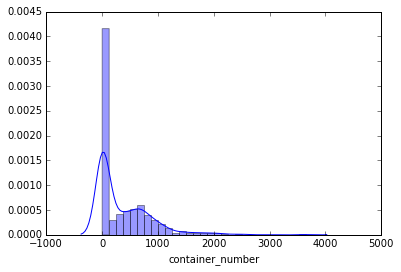

In [32]:
#view the distribution of containers by month
sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

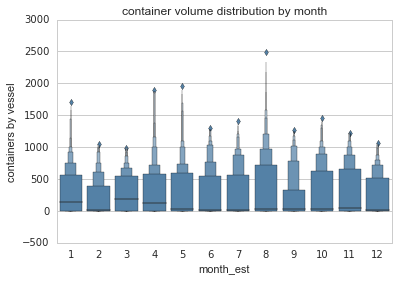

In [172]:
#view the distribution by month of 
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_est", y="container_number", data=voyage_stats, color = 'steelblue')
ax.set_ylabel('containers by vessel')
ax.set_title('container volume distribution by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

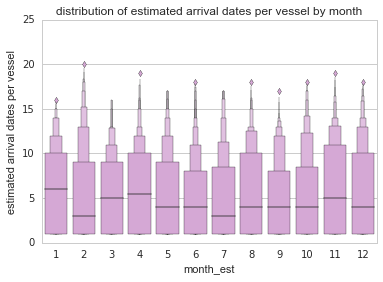

In [234]:
#view the distribution by month of 
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_est", y="estimated_arrival_date", data=voyage_stats, color = 'plum')
ax.set_ylabel('estimated arrival dates per vessel')
ax.set_title('distribution of estimated arrival dates per vessel by month')
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

[(0, 25)]

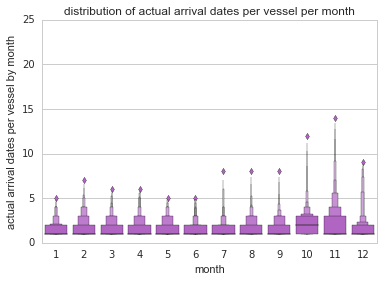

In [247]:
#view the distribution by month of 
sns.set(style="whitegrid")
ax = sns.lvplot(x="month_est", y="actual_arrival_date", data=voyage_stats, color = 'mediumorchid')
ax.set_xlabel('month')
ax.set_ylabel('actual arrival dates per vessel by month')
ax.set_title('distribution of actual arrival dates per vessel per month')
ax.set(ylim=(0, 25))
#sns.distplot(voyage_stats.container_number)
#sns.distplot(voyage_stats.container_number, bins=20, kde=False, rug=True);

In [210]:
#arrivals per vessel
print len(voyage_stats[voyage_stats.actual_arrival_date > 2]), len(voyage_stats)
print round(len(voyage_stats[voyage_stats.actual_arrival_date > 2])/ (len(voyage_stats) * 1.0),4)

227 1365
0.1663


** Consider using only vessels observations that have at most two actual arrival dates per month **


In [248]:
#subset voyage stats to only vessels that had at most 2 actual arrival dates
voyage_stats2 = voyage_stats[voyage_stats.actual_arrival_date <= 2]

In [252]:
#compare freight volumes percent of original remaining
round(voyage_stats2.container_number.sum() / (voyage_stats.container_number.sum() * 1.0),4)

0.6628

This will drop 34% of the containers, which seems like too large a percentage to drop.

** Problems Encountered **  
  
Data Cleaning Issues:   
- ship names are not clean - there are different spellings for the same ship
- there are errors in the data - non-2014 dates appear (this only 1% of the time and can be removed from the dataset)

Data Integrity Issues:  

